In [ ]:
# Try to append data to existing excel file, while checking first if file there try find file, 
# if found append excel method else create file
# Create info essentials, test new info def

In [1]:
from random import randint
from time import sleep
import datetime
import yfinance as yf
import openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

In [224]:
# Def for reading the ticker file as csv: csv_ticker('filename.csv', 'columnname')
def csv_ticker(csv_file, ticker_col):
    df = pd.read_csv(csv_file)
    df_tick = df[ticker_col].drop_duplicates(keep='first').dropna()
    return df_tick

# Def for reading the ticker file as xlsx: xlsx_ticker('filename.xlsx', 'columnname') returns "df_tick"
def xlsx_ticker(xlsx_file, ticker_col):
    df = pd.read_excel(xlsx_file)
    df_tick = df[ticker_col].drop_duplicates(keep='first').dropna()
    return df_tick

# Def for reading collected data after preprocessing through “def info()“ and “def fin()“
def csv_df(csv_file):
    df = pd.read_csv(csv_file)
    return df

def xlsx_df(xlsx_file):
    df = pd.read_excel(xlsx_file)
    return df

# Def for data export
def export_xlsx(df):
    now = datetime.datetime.now()
    now = now.strftime("%Y.%m.%d %H_%M_%S")
    len_df = str(len(df))
    return df.to_excel('df_'+'_'+len_df+'_'+now+'.xlsx'), print('Successfully stored as xlsx')

In [3]:
# DF OPERATIONS A) READING B) APPENDING C) JOINING D) UPDATING
# A) Analysis constists of 3 tables: stock advisor company info = df_1, 
#    SnP500 company info = df_2, stock tips = df_adv
df_1 = xlsx_df('test.info.xlsx')
df_2 = csv_df('df_info_465_2021.10.04 21_31_53.csv')
df_adv = csv_df('advisor stocks.csv')

# B) Company info tables are appended
df_1 = df_1.append(df_2)

    # Duplicates are dropped to join with stock tips df_adv
df_1 = df_1.drop_duplicates(subset=['symbol'])
df_1.shape


# Stock tips df_adv has to be prepared for left join, renaming, drop duplicates

    # rename key_column
df_adv = df_adv.rename(columns={'ticker': 'symbol', 'symbol':'symbol_'})

    # drop duplicates with same symbol/ ticker
df_adv = df_adv.drop_duplicates(subset=['symbol'])
df_adv

# C) left join on 'symbol' getting columns 'status_advisor', 'date_advisor', 'price_when_advised', 'source_advisor'
df_1 = pd.merge(df_1, df_adv[['symbol','status_advisor','date_advisor',
                             'price_when_advised','source_advisor']],on='symbol', how='left')

In [ ]:
# Storing the result to prepare df for K-means
now = datetime.datetime.now()
now = now.strftime("%Y.%m.%d %H_%M_%S")
len_df_1 = str(len(df_1))
#df_1.to_excel('df_1'+len_df+'_'+now+'.xlsx')

In [255]:
df_1.shape

(734, 187)

In [245]:
# CALCULATION OF EV RATIOS AND CREATION OF RANKING IN DF_1

df_1['EV_calc'] = df_1['sharesOutstanding'] * df_1['currentPrice'] + df_1['totalDebt'] - df_1['totalCash']
df_1['EV_52high'] = df_1['sharesOutstanding'] * df_1['fiftyTwoWeekHigh'] + df_1['totalDebt'] - df_1['totalCash']
df_1['EV_52low'] = df_1['sharesOutstanding'] * df_1['fiftyTwoWeekLow'] + df_1['totalDebt'] - df_1['totalCash']
df_1['SalesoEV_in_%'] = (df_1['totalRevenue'] / df_1['EV_calc'])*100
df_1['EBITDAoEV_in_%'] = (df_1['ebitda'] / df_1['EV_calc'])*100
df_1['CFoEV_in_%'] = (df_1['freeCashflow'] / df_1['EV_calc'])*100
df_1['Rank_SalesoEV'] = df_1['SalesoEV_in_%'].rank(ascending=False)
df_1['Rank_EBITDAoEV'] = df_1['EBITDAoEV_in_%'].rank(ascending=False)
df_1['Rank_CFoEV'] = df_1['CFoEV_in_%'].rank(ascending=False)
df_1['Rank_RoA'] = df_1['returnOnAssets'].rank(ascending=False)
df_1['Rank_CFoEV_RoA'] = (df_1['Rank_CFoEV']+df_1['Rank_RoA']).rank(ascending=True)

# Calculation of ranks within each cluster df.loc[df['column_name'] == some_value]

In [268]:
# Calculation of ranks within each cluster df.loc[df['column_name'] == some_value]
# Tried with filter: df_1['C_Rank_CFoEV'] = df_1['CFoEV_in_%'].rank(ascending=False).loc[df_1['cluster'] == 5]
g = df_1.groupby('cluster')
g.get_group(0)
#g.get_group(5)['C_Rank_CFoEV'] = df_1['CFoEV_in_%'].rank(ascending=False)
#g.get_group(5)['C_Rank_RoA'] = df_1['returnOnAssets'].rank(ascending=False)
#g.get_group(5)['C_Rank_CFoEV_RoA'] = (df_1['C_Rank_CFoEV']+df_1['C_Rank_RoA']).rank(ascending=True)

,Unnamed: 0,zip,sector,fullTimeEmployees,longBusinessSummary,city,phone,country,companyOfficers,website,...,EV_52low,SalesoEV_in_%,EBITDAoEV_in_%,CFoEV_in_%,Rank_SalesoEV,Rank_EBITDAoEV,Rank_CFoEV,Rank_RoA,Rank_CFoEV_RoA,cluster
3,0,56070,Healthcare,8030,CompuGroup Medical SE & Co. KGaA develops and ...,Koblenz,49 261 8000 0,Germany,[],http://www.cgm.com,...,3.689172e+09,23.033157,4.038915,3.254243,362.0,426.0,277.0,337.0,325.0,0.0
7,0,22419,Healthcare,3914,Evotec SE provides drug discovery and developm...,Hamburg,49 40 5 60 81 0,Germany,[],http://www.evotec.com,...,3.644902e+09,8.030780,1.173909,-0.601231,591.0,556.0,569.0,526.0,574.0,0.0
13,0,44269,Technology,5309,adesso SE operates as an IT service provider f...,Dortmund,49 231 7000 7000,Germany,[],http://www.adesso.de,...,5.428162e+08,48.458033,4.956465,1.209799,187.0,373.0,487.0,182.0,364.0,0.0
14,0,69115,Technology,1576,SNP Schneider-Neureither & Partner SE provides...,Heidelberg,49 6221 6425 0,Germany,[],http://www.snpgroup.com,...,3.461124e+08,36.339353,3.664265,-3.128248,250.0,458.0,616.0,399.5,530.0,0.0
19,0,61352,Healthcare,312734,"Fresenius SE & Co. KGaA, a health care group, ...",Bad Homburg vor der HÃ¶he,49 6172 608 2485,Germany,[],http://www.fresenius.com,...,4.235501e+10,76.341697,12.442281,4.462741,109.0,82.0,195.0,379.0,291.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,0,30328,Consumer Cyclical,11000,WestRock Company manufactures and sells paper ...,Atlanta,770 448 2193,United States,[],http://www.westrock.com,...,1.868166e+10,76.852922,11.629571,7.157646,106.0,94.0,99.0,468.5,286.0,0.0
720,0,98104,Real Estate,9400,"Weyerhaeuser Company, one of the world's large...",Seattle,206-539-3000,United States,[],http://www.weyerhaeuser.com,...,2.340264e+10,32.440087,13.110775,5.089094,270.0,75.0,165.0,74.0,41.0,0.0
723,0,EC3M 7DQ,Financial Services,46000,Willis Towers Watson Public Limited Company op...,London,44 20 3124 6000,United Kingdom,[],http://www.willistowerswatson.com,...,2.727387e+10,27.304013,6.903801,5.539104,316.5,256.5,147.5,435.5,301.5,0.0
726,0,55401,Utilities,11367,"Xcel Energy Inc., through its subsidiaries, ge...",Minneapolis,612-330-5500,United States,[],http://www.xcelenergy.com,...,5.421359e+10,21.229581,7.434510,-3.414990,391.0,233.0,620.0,472.0,570.5,0.0


In [252]:
display(df_1[['shortName','symbol','financialCurrency','EV_calc',
              'EV_52high','EV_52low','SalesoEV_in_%',
              'EBITDAoEV_in_%','CFoEV_in_%','Rank_SalesoEV','Rank_EBITDAoEV','Rank_CFoEV','Rank_RoA',
              'Rank_CFoEV_RoA','beta']])

,shortName,symbol,financialCurrency,C_Rank_CFoEV,C_Rank_RoA,C_Rank_CFoEV_RoA,EV_calc,EV_52high,EV_52low,SalesoEV_in_%,EBITDAoEV_in_%,CFoEV_in_%,Rank_SalesoEV,Rank_EBITDAoEV,Rank_CFoEV,Rank_RoA,Rank_CFoEV_RoA,beta
0,KAPSCH TRAFFICCOM AG,BZ6.F,EUR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,675.0,NaN,0.710946
1,DUERR AG O.N.,DUE.DE,EUR,NaN,NaN,NaN,2.567303e+09,3.083550e+09,1.696740e+09,130.192864,5.627540,6.462035,46.0,336.0,118.0,563.0,375.0,1.750285
2,EXASOL AG NA O.N.,EXL.DE,EUR,NaN,NaN,NaN,2.447863e+08,6.563009e+08,2.292889e+08,11.726631,-10.229576,-5.719862,527.0,672.0,640.0,720.0,673.0,NaN
3,COMPUGROUP MED. NA O.N.,COP.DE,EUR,NaN,NaN,NaN,4.231161e+09,5.044144e+09,3.689172e+09,23.033157,4.038915,3.254243,362.0,426.0,277.0,337.0,325.0,0.836374
4,NFON AG INH O.N.,NFN.DE,EUR,NaN,NaN,NaN,2.756274e+08,3.484134e+08,1.928218e+08,26.378732,0.363897,-1.098721,325.0,583.0,583.0,641.0,621.0,1.646321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,Xylem Inc.,XYL,USD,NaN,NaN,NaN,2.280022e+10,2.628223e+10,1.644473e+10,22.806801,3.837683,2.509296,366.0,446.0,354.0,342.0,385.5,1.032751
730,"Yum! Brands, Inc.",YUM,USD,361.0,14.0,45.0,4.771819e+10,5.150302e+10,3.841325e+10,13.158505,4.845113,2.468923,513.0,385.0,361.0,14.0,120.0,1.031659
731,"Zimmer Biomet Holdings, Inc.",ZBH,USD,NaN,NaN,NaN,3.737257e+10,4.442551e+10,3.393678e+10,21.108799,6.430385,3.388281,393.0,285.0,270.0,401.0,368.5,1.323144
732,Zions Bancorporation N.A.,ZION,USD,NaN,NaN,NaN,-3.064467e+07,8.566469e+07,-5.582369e+09,-10439.008987,NaN,NaN,731.0,NaN,NaN,543.5,NaN,1.563864


In [254]:
# Clean df to recalculate --> df.drop(['B', 'C'], axis=1, inplace=True)
# https://stackoverflow.com/questions/13411544/delete-a-column-from-a-pandas-dataframe
df_1.drop(['C_Rank_CFoEV','C_Rank_RoA','C_Rank_CFoEV_RoA'], axis=1, inplace=True)
#df_1.drop(['EV_calc','EV_52high','EV_52low','SalesoEV_in_%','EBITDAoEV_in_%','CFoEV_in_%',
#          'Rank_SalesoEV','Rank_EBITDAoEV','Rank_CFoEV','Rank_RoA','Rank_CFoEV_RoA'], axis=1, inplace=True)

In [198]:
# K-MEANS DATA PREPARATION
# Selecting columns for K-means clustering. Selection of columns:
# ('shortName', 'longName', 'symbol', 'sector', 'industry', 'city', 'state', 'country', 'financialCurrency',
# 'revenueGrowth', 'earningsGrowth', 'debtToEquity', 'totalRevenue', 'priceToBook', 'forwardPE', 'payoutRatio', 
# 'trailingAnnualDividendRate', 'trailingPE', 'marketCap', 'ebitdaMargins', 'profitMargins', 'grossMargins', 
# 'returnOnAssets', 'enterpriseToRevenue', 'enterpriseToEbitda', 'beta')

df_k = df_1[['shortName','symbol','financialCurrency',
             'returnOnAssets','revenueGrowth','grossMargins','ebitdaMargins','trailingPE','beta']]

# Filling the dividend information with 0 instead of nan | Watch out warnings override if there is an error
#df_k[['trailingAnnualDividendRate','payoutRatio']] = df_k[['trailingAnnualDividendRate','payoutRatio']].fillna(0)
#df_k['payoutRatio'] = df_k['payoutRatio'].fillna(0)

# Dropping the other nan values for now
df_k = df_k.dropna()

# Statistics overview:
display(df_k.shape)
display(df_k.info())
display(df_k.describe())

(690, 9)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 1 to 733
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   shortName          690 non-null    object 
 1   symbol             690 non-null    object 
 2   financialCurrency  690 non-null    object 
 3   returnOnAssets     690 non-null    float64
 4   revenueGrowth      690 non-null    float64
 5   grossMargins       690 non-null    float64
 6   ebitdaMargins      690 non-null    float64
 7   trailingPE         690 non-null    float64
 8   beta               690 non-null    float64
dtypes: float64(6), object(3)
memory usage: 53.9+ KB


None

,returnOnAssets,revenueGrowth,grossMargins,ebitdaMargins,trailingPE,beta
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.049912,30.287864,0.446518,0.184512,94.103795,1.195497
std,0.077487,779.242316,0.249180,0.242613,519.860979,0.608246
min,-0.300700,-0.998000,-0.807090,-1.538480,2.654497,-1.710515
25%,0.016772,0.087500,0.283230,0.078360,17.548717,0.811799
50%,0.043810,0.226500,0.446245,0.188350,28.651775,1.139737
75%,0.080497,0.432750,0.624000,0.315305,48.582172,1.504227
max,0.651200,20469.477000,1.000000,0.906300,11919.999000,4.780423


In [199]:
# Check for outliers in features and drop them

#df_k.nlargest(10,['revenueGrowth','payoutRatio',  'trailingPE', 'marketCap']) # 121 CRSP
#df_k.nlargest(10,['payoutRatio',  'trailingPE', 'marketCap']) # 692 UDR
#df_k.nlargest(10,['trailingPE', 'marketCap']) # maybe 403 COP ConocoPhilips
#df_k.nlargest(10,['marketCap']) # none
#df_k.nlargest(10,['priceToBook','debtToEquity']) # none
#df_k.nlargest(10,['debtToEquity']) # none
#df_k.nlargest(10,['returnOnAssets', 'revenueGrowth', 'grossMargins', 'ebitdaMargins','trailingPE'])
df_k.nlargest(10,['revenueGrowth', 'grossMargins', 'ebitdaMargins','trailingPE'])
#df_k.nlargest(10,['grossMargins', 'ebitdaMargins','trailingPE'])
#df_k.nlargest(10,['ebitdaMargins','trailingPE'])
#df_k.nlargest(10,['returnOnAssets', 'enterpriseToRevenue', 'enterpriseToEbitda', 'beta'])
#df_k.nlargest(10,['enterpriseToRevenue', 'enterpriseToEbitda', 'beta'])
#df_k.nlargest(10,['enterpriseToEbitda', 'beta'])
#df_k.nlargest(10,['beta'])
#df_k.nsmallest(10,['revenueGrowth','payoutRatio',  'trailingPE', 'marketCap'])
#df_k.nsmallest(10,['payoutRatio',  'trailingPE', 'marketCap'])
#df_k.nsmallest(10,['trailingPE', 'marketCap'])
#df_k.nsmallest(10,['marketCap'])
#df_k.nsmallest(10,['priceToBook','debtToEquity']) # none
#df_k.nsmallest(10,['debtToEquity']) # none

#print(df_k['revenueGrowth'].idxmax())
#df_k.loc[121:121,"symbol"]

# Drop a row by index: df.drop([indexnumber, indexnumber])
df_k.drop([121,692,403], inplace=True)

In [200]:
# Taking the numerical columns --> select_dtypes(include=[np.number]).dtypes).
# Storing the numerical df as X to move on with standardization, as the data is wide spread
df_k_num = df_k.select_dtypes(include=['float64'])
X = df_k_num
X.shape

In [226]:
df_k.shape

(687, 10)

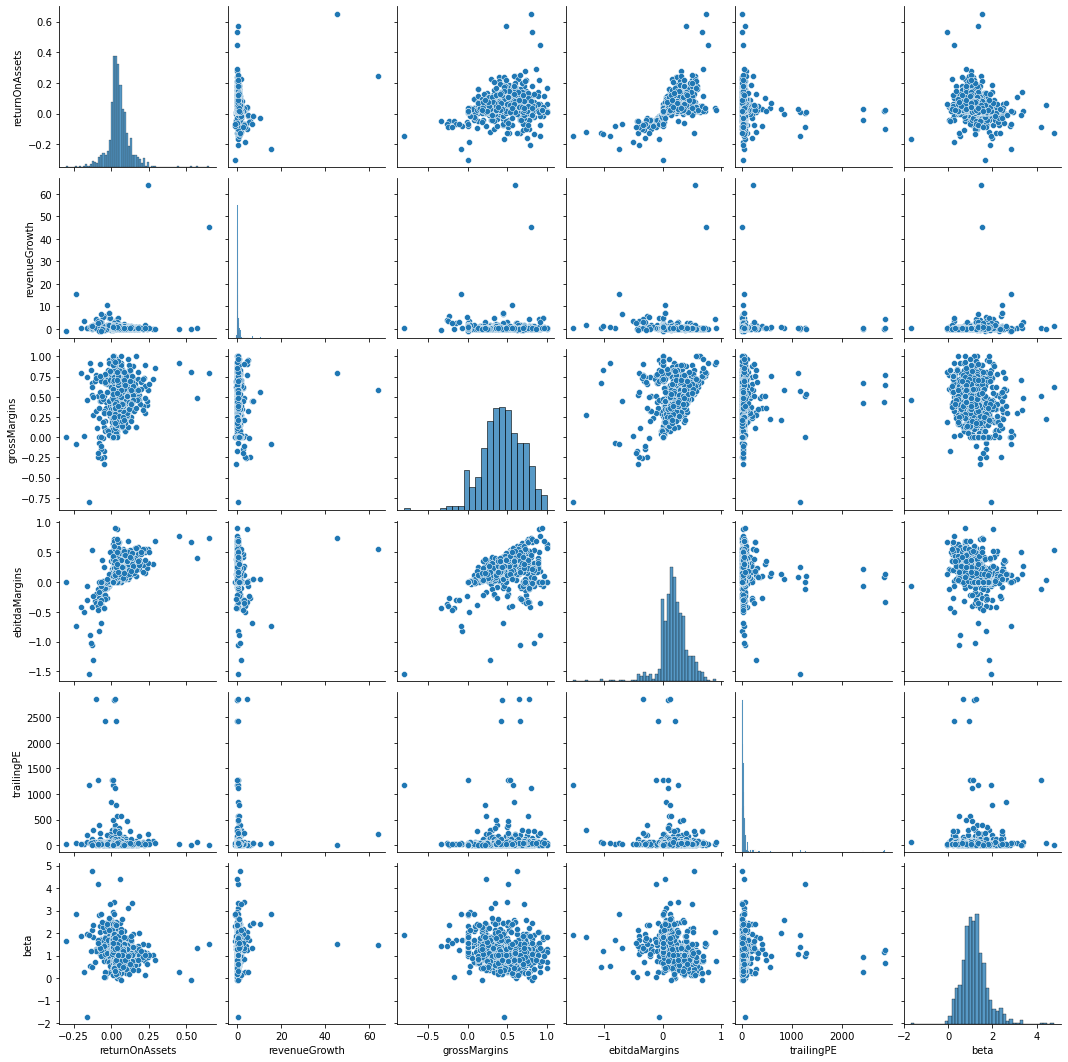

In [202]:
sns.pairplot(X)
plt.show()

In [231]:
if any(df_k.columns.str.contains('cluster')):     #https://stackoverflow.com/questions/34472814/use-a-any-or-a-all
    print("Column 'cluster' already concatinated.")

Column 'cluster' already concatinated.


In [203]:
# 1. Scaling features

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head())
print()
display(X_scaled_df.head())
X_scaled_df.describe()

,returnOnAssets,revenueGrowth,grossMargins,ebitdaMargins,trailingPE,beta
1,0.01104,0.091,0.20667,0.04322,125.410960,1.750285
3,0.04650,0.316,0.37123,0.17535,52.999240,0.836374
4,-0.01891,0.160,0.38878,0.01379,52.999240,1.646321
5,0.02513,0.291,0.83734,0.14498,105.835800,0.771998
6,0.06056,-0.011,0.71777,0.26134,23.425348,0.927594


,returnOnAssets,revenueGrowth,grossMargins,ebitdaMargins,trailingPE,beta
0,-0.501105,-0.168227,-0.959812,-0.578293,0.188940,0.916548
1,-0.043549,-0.096824,-0.299799,-0.032430,-0.090606,-0.588678
2,-0.887564,-0.146330,-0.229410,-0.699876,-0.090606,0.745317
3,-0.319296,-0.104758,1.569662,-0.157896,0.113370,-0.694706
4,0.137873,-0.200596,1.090094,0.322817,-0.204777,-0.438437


,returnOnAssets,revenueGrowth,grossMargins,ebitdaMargins,trailingPE,beta
count,6.870000e+02,6.870000e+02,6.870000e+02,6.870000e+02,6.870000e+02,6.870000e+02
mean,1.249203e-16,-2.018036e-17,-1.755025e-16,-3.031701e-16,-7.603492e-17,-2.512950e-16
std,1.000729e+00,1.000729e+00,1.000729e+00,1.000729e+00,1.000729e+00,1.000729e+00
min,-4.523626e+00,-5.138160e-01,-5.025775e+00,-7.112709e+00,-2.849632e-01,-4.783443e+00
25%,-4.252977e-01,-1.691789e-01,-6.536700e-01,-4.351659e-01,-2.276363e-01,-6.280194e-01
50%,-7.722722e-02,-1.253852e-01,-1.947066e-04,1.454262e-02,-1.846002e-01,-9.352913e-02
75%,3.945873e-01,-6.017069e-02,7.109558e-01,5.329745e-01,-1.099087e-01,5.056617e-01
max,7.759165e+00,2.010824e+01,2.222055e+00,2.987315e+00,1.072000e+01,5.907232e+00


687


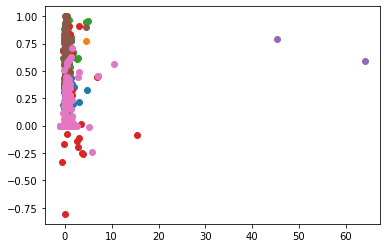

In [204]:
# Defining the KMeans https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters=7, init="k-means++", n_init=150, max_iter=350, tol=0.1, algorithm="elkan", 
                random_state=1234)
kmeans.fit(X_scaled_df)

print(len(kmeans.labels_))

# assign a cluster to each example
labels = kmeans.predict(X_scaled_df)

# retrieve unique clusters
clusters = np.unique(labels)

# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    plt.scatter(X.to_numpy()[row_ix, 1], X.to_numpy()[row_ix, 2])

# show the plot
plt.show()

In [205]:
# Review clusters and observations per cluster
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index()

0    239
1     10
2    124
3     36
4      2
5    175
6    101
dtype: int64

In [248]:
# Assigning the clusters back to the companies

#X_df = pd.DataFrame(X)

if any(df_k.columns.str.contains('cluster')):     #https://stackoverflow.com/questions/34472814/use-a-any-or-a-all
    print("Column 'cluster' already concatinated to df_k.")
else:
    df_k["cluster"] = clusters
    display(df_k.head(9))

    # Exporting as xlsx to save clustering
    export_xlsx(df_k)

# Left join on 'symbol' getting columns 'cluster' concatenated to the main df df_1
if any(df_1.columns.str.contains('cluster')):
        print("Column 'cluster' already concatinated to df_1.")
else:
    df_1 = pd.merge(df_1, df_k[['symbol','cluster']],on='symbol', how='left')
    display(df_1.head(9))

Column 'cluster' already concatinated to df_k.
Column 'cluster' already concatinated to df_1.


In [247]:
# Left join on 'symbol' getting columns 'cluster' concatenated to the main df df_1
df_1 = pd.merge(df_1, df_k[['symbol','cluster']],on='symbol', how='left')

In [269]:
# Extracting the result for user input
export_xlsx(df_1)

Successfully stored as xlsx


(None, None)

In [137]:
# Parameter tuning - first checking the inertia, then checking different settings
print('inertia of kmeans1:',kmeans.inertia_)

kmeans2 = KMeans(n_clusters=5,
                init="k-means++",
                n_init=250,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=500, tol=0, algorithm="elkan", random_state=1234)
kmeans2.fit(X_scaled_df)
print('inertia of kmeans2:',kmeans2.inertia_)

inertia of kmeans1: 1283.580788296457
inertia of kmeans2: 1917.7097904610152


Text(0.5, 1.0, 'Elbow Method displaying the optimal k')

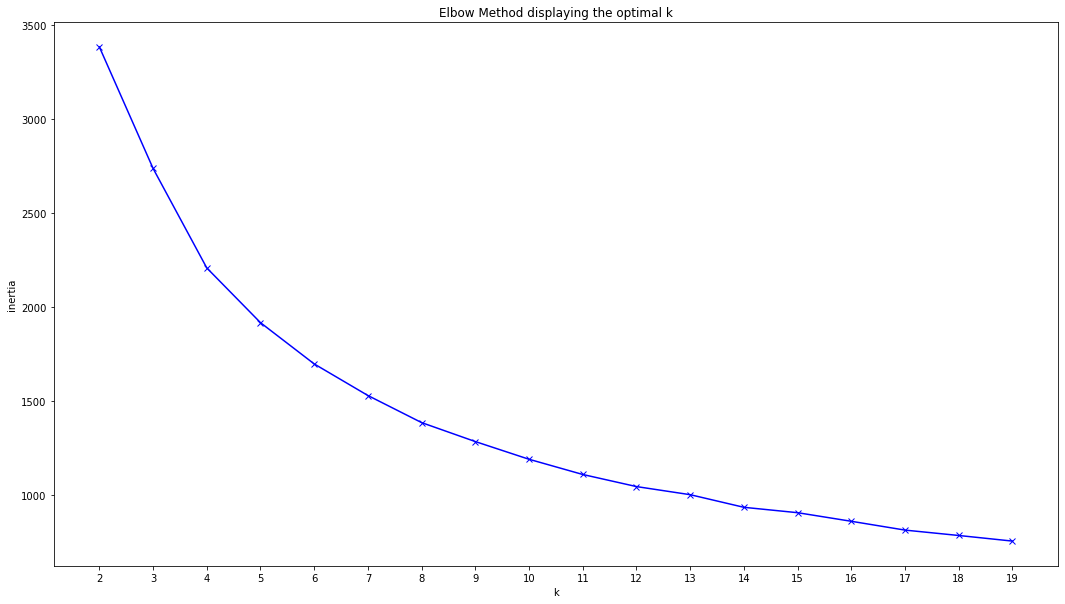

In [138]:
# Finding k with the elbow method

K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(18,10))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method displaying the optimal k')

Text(0.5, 1.0, 'Silhouette Method displaying the optimal k')

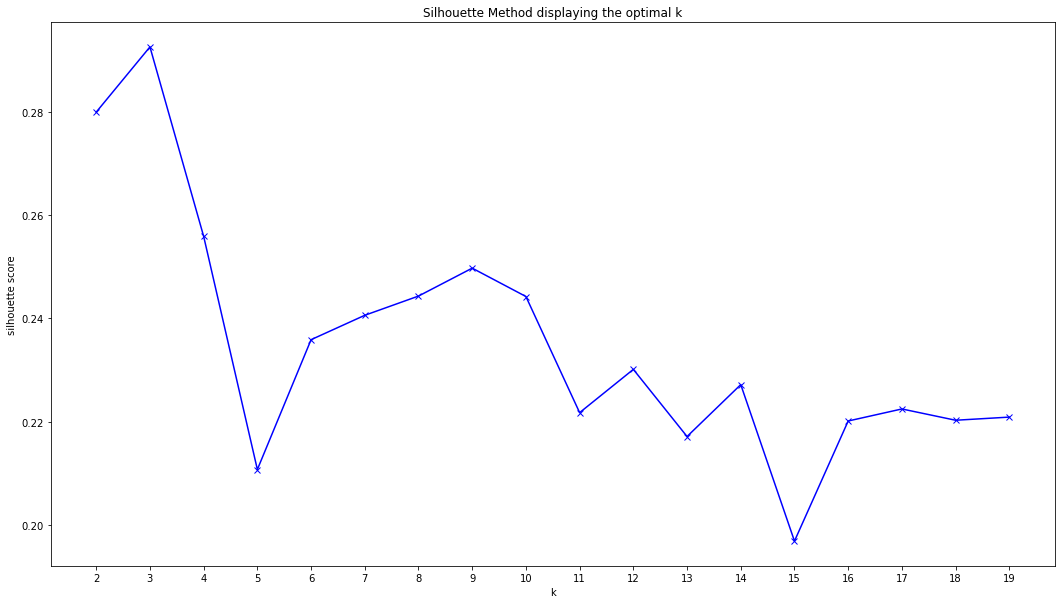

In [139]:
# Finding k with the Silhouette Method

K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))

plt.figure(figsize=(18,10))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method displaying the optimal k')

In [ ]:
# TESTING with samples for extraction of data
# splitting dataframe by row index to create test samples for data downloading
df_1 = df_tick.iloc[:5]
df_2 = df_tick.iloc[5:] # tested 20-50 (did not work). works until 46, 49-50 works fine 9-50 are missing now
df_3 = df_tick.iloc[51:100]
df_3 = df_tick.iloc[101:200]
df_4 = df_tick.iloc[201:]
print("Shape of new dataframes - {} , {} , {} , {}".format(df_1.shape, df_2.shape, df_3.shape, df_4.shape))

In [ ]:
#Example tickers: ticker_list = ['BZ6.F',	'DUE.DE',	'EXL.DE',	'COP.DE',	'NFN.DE',	'MED.SW',
#                'SAP.DE',	'EVT.DE',	'AAG.DE',	'LPK.DE',	'OSP2.DE',	'ADN1.DE',	'SHF.DE',	
#               'SANT.DE',	'AOF.DE'] # example list
# Dict. ticker_info_dict has to be created to store information coming from .info function
# Within dict. values have to be iterable (lists, tuples, dict., sets) values returned from .info have to be 
# transformed into list. List of 308 ticker took circa 25 min.

def info(df):
    ticker_info_dict = {}
    ticker_info_dict2 = {}
    info_list = []
    total_number = 0
    total_passed = 0
    
    for tick in df:
        try:
            ticker_item = yf.Ticker(tick) 
            ticker_info_dict = ticker_item.info # to be created to store information coming from .info function
            print('Starting to loop through dict. of', tick)

            for key, value in ticker_info_dict.items():  # Within dict. values have to be iterable 
                                                         #(lists, tuples, dict., sets) values returned 
                                                         # from .info have to be transformed into list.
                ticker_info_dict2[key] = [value]

            a = pd.DataFrame.from_dict(ticker_info_dict2)
            info_list.append(a)
               
            total_number = total_number + 1
            print('Nr: ' + str(total_number), tick)
        except Exception as e:
            total_passed = total_passed + 1
            print('Nr: ' + str(total_passed), tick, 'Passed!', e)
            #passed_df.append(tick, e)
            #passed_df.append([ticker, e]) # e text of exception, to understand reason why passed
            pass
    df_info = pd.concat(info_list, sort=False)  # transform info_list into df
    df_info.fillna(0)
    
    
    print('Start saving stock data...')

    #Create variables for specific naming of file, to not overwrite data
    #Later file shall be overwritten or appended for purpose of updating
    now = datetime.datetime.now()
    now = now.strftime("%Y.%m.%d %H_%M_%S")
    len_df = str(len(df))

    df_info.to_csv('df_info_'+len_df+'_'+now+'.csv')

    print('Stock data saved!')

In [ ]:
def fin(df):
        balance_list = []
        cashflow_list = []
        financials_list = []
        total_number = 0
        total_passed = 0
        passed_df = []
        
        for tick in df:
            try:
                ticker = yf.Ticker(tick)
                a = ticker.balancesheet.T   # T stands for transpose
                if a.index.dtype.kind == 'M':  # Check if ticker is valid, if no data can be found then index.dtype
                                               # is an object and index is filled 
                                               # with ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
                    a.insert(0, 'ticker', tick)
                    b = ticker.cashflow.T
                    b.insert(0, 'ticker', tick)
                    c = ticker.financials.T
                    c.insert(0, 'ticker', tick)

                    balance_list.append(a)
                    cashflow_list.append(b)
                    financials_list.append(c)

                    total_number = total_number + 1
                    print('Nr: ' + str(total_number), tick)
                else:
                    total_passed = total_passed + 1
                    print('Nr: ' + str(total_passed), tick, 
                          'Passed! Ticker is empty or has no datetime index with index.dtype:', a.index.dtype)
            except Exception as e:
                total_passed = total_passed + 1
                print('Nr: ' + str(total_passed), tick, 'Passed!', e)
                #passed_df.append(tick, e)
                #passed_df.append([ticker, e]) # e text of exception, to understand reason why passed
                pass

        df_balance = pd.concat(balance_list, sort=False)
        df_balance.insert(1, 'Date', pd.DatetimeIndex(df_balance.index).date) # Add try except for date column issue
        df_balance.fillna(0)

        df_cashflow = pd.concat(cashflow_list, sort=False)
        df_cashflow.insert(1, 'Date', pd.DatetimeIndex(df_cashflow.index).date)
        df_cashflow.fillna(0)

        df_financials = pd.concat(financials_list, sort=False)
        df_financials.insert(1, 'Date', pd.DatetimeIndex(df_financials.index).date)
        df_financials.fillna(0)
        try:
            df_passed = pd.concat(passed_df, sort=False)
        except Exception as e:
            print(e)
            pass
        print('Start saving stock data...')
        #df_pass = pd.DataFrame(Screener.globalpass, index=None, columns={'Ticker', 'Error'})
        
        #Create variables for specific naming of the files, to not overwrite data
        #Later files shall be overwritten or appended for purpose of updating
        now = datetime.datetime.now()
        now = now.strftime("%Y.%m.%d %H_%M_%S")
        len_df = str(len(df))
        
        df_balance.to_csv('balance_'+len_df+'_'+now+'.csv')
        df_cashflow.to_csv('cashflow_'+len_df+'_'+now+'.csv')
        df_financials.to_csv('financials_'+len_df+'_'+now+'.csv')
        
        print('Stock data saved!')
        
        #Writer not needed, as analysis will be conducted with CSV format
        #writer = pd.ExcelWriter('merge.xlsx')
        #df_balance.to_excel(writer, 'Balances', index=False)
        #df_cashflow.to_excel(writer, 'Cashflows', index=False)
        #df_financials.to_excel(writer, 'Financials', index=False)
        #writer.save()

In [ ]:
def info_essentials(df)
    ticker_info_dict = {}
    ticker_info_dict2 = {}
    info_list = []
    total_number = 0
    total_passed = 0
    
    for tick in df:
        try:
            ticker_item = yf.Ticker(tick)
            ticker_info_dict = ticker_item.info # define here the few needed items to speed up the download
            print('Starting to loop through dict. of', tick)

            for key, value in ticker_info_dict.items():
                ticker_info_dict2[key] = [value]

            a = pd.DataFrame.from_dict(ticker_info_dict2)
            info_list.append(a)
               
            total_number = total_number + 1
            print('Nr: ' + str(total_number), tick)
        
        except Exception as e:
            total_passed = total_passed + 1
            print('Nr: ' + str(total_passed), tick, 'Passed!', e)
            #passed_df.append(tick, e)
            #passed_df.append([ticker, e]) # e text of exception, to understand reason why passed
            pass
        
    df_info = pd.concat(info_list, sort=False)  # transform info_list into df
    df_info.fillna(0)
    df_info.to_excel('test.info.xlsx')

In [ ]:
# show income statement
dic_msft_fin={}
#dic_msft_fin = msft.financials
#msft.quarterly_financials

# show balance heet
dic_msft_bal={}
dic_msft_bal=msft.balance_sheet
msft.quarterly_balance_sheet

# show cashflow
dic_msft_cash={}
#dic_msft_cash=msft.cashflow
#msft.quarterly_cashflow

# show earnings
msft.earnings
msft.quarterly_earnings

# show sustainability
msft_profile=msft.sustainability

# show analysts recommendations
msft.recommendations

# show major holders
msft.major_holders

# show institutional holders
msft.institutional_holders

In [ ]:
# df['symbol']
# user input = 'AAPL'
# df.loc[df['symbol']==user input]
# if len(df.loc[df['symbol']==user input]) ==1
#    print('The following company was found:')
#    elif len(df.loc[df['symbol']==user input]) > 1
# df = df.loc
    

In [ ]:
# Selection idea
def user_selection():
    for index, item in enumerate(options):
                print(f"Option {index + 1} - {item}")
            while True:
                try: # Is used to avoid errors
                    choice = int(input("Selection: "))
                    if choice >= 1 and choice <= len(options):
                        return options[choice-1]
                except:
                    continue